In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns, warnings

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family='NanumGothic')
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR, SVR
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [3]:
df_raw = pd.read_csv('../data/jeju_data_ver1/201901-202003.csv')

In [ ]:
df_raw.head()

#### 1, 2, 3월 데이터만 추출

In [4]:
# df = df_raw[(df_raw['REG_YYMM'] == 202001) | (df_raw['REG_YYMM'] == 202002) | (df_raw['REG_YYMM'] == 202003)]
# df.head()

#### 서울 데이터만 추출

In [5]:
df = df_raw[df_raw['CARD_SIDO_NM']=='서울']

In [6]:
df.fillna('세종시', inplace=True)

In [7]:
df.columns

Index(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',
       'HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'AMT', 'CNT'],
      dtype='object')

In [8]:
df.drop(['CARD_CCG_NM','HOM_SIDO_NM','HOM_CCG_NM'], axis=1, inplace=True)

In [9]:
df = df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']).sum().reset_index()

In [23]:
df['CV'] = 0
df.loc[df['REG_YYMM']==202001, 'CV'] = 1
df.loc[df['REG_YYMM']==202002, 'CV'] = 2
df.loc[df['REG_YYMM']==202003, 'CV'] = 3

# 군집분석

In [50]:
new_df = df.groupby(['STD_CLSS_NM'])['CSTMR_CNT', 'AMT', 'CNT'].sum().reset_index()

cl_df = new_df[['CSTMR_CNT', 'AMT', 'CNT']]
cl_df.tail()

,CSTMR_CNT,AMT,CNT
34,68168586,1575084395358,207704708
35,21812201,302413723895,32626670
36,65791764,2999269686135,110377094
37,1165704,132363116112,2385404
38,4185944,303576934373,5309967


#### 표준화 및 역할 정의

In [51]:
X_list = list(cl_df.columns)
# 데이터 표준화
scaler = StandardScaler()
new_df_x = scaler.fit_transform(cl_df[X_list])

## k-평균 군집분석

#### 군집 개수 찾기 : 각 데이터로부터 가장 가까운 군집 중심점까지의 거리 제곱합


In [60]:
# 최대 군집 생성 개수
n_iter_cluster = 5
cluster_range = [i+1 for i in range(n_iter_cluster)]
clus_error = []
for v_n_clus in cluster_range : 
    clus = KMeans(v_n_clus)
    clus.fit(new_df_x)
    # 각 데이터로 부터 가장 가까운 군집 중심점까지 거리 제곱합
    clus_error.append(clus.inertia_)
ds_error = pd.DataFrame({'NumberofCluster' : cluster_range,
                        'Error' : clus_error})
ds_error

,NumberofCluster,Error
0,1,117.000000
1,2,34.378965
2,3,16.098807
3,4,8.689328
4,5,5.351182


#### 4-2) 군집별 군집 중시점까지 거리 제곱합 시각화

Text(0, 0.5, 'Sum of squared distance')

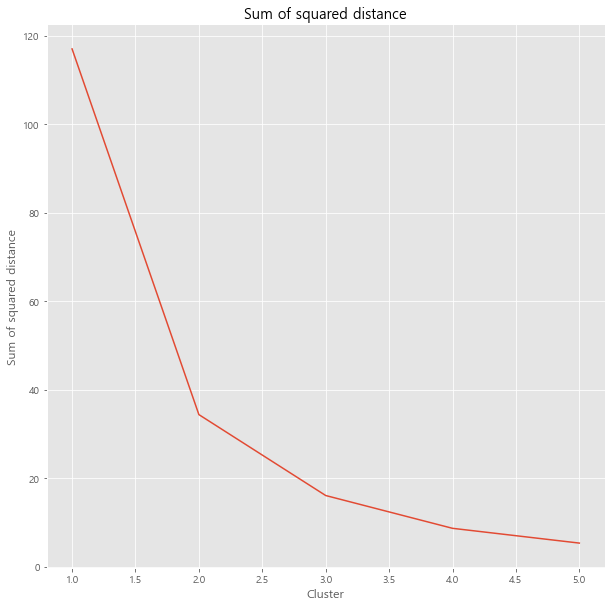

In [61]:
plt.figure(figsize = (10,10))
plt.plot(ds_error['NumberofCluster'], ds_error['Error'])
plt.title("Sum of squared distance")
plt.xlabel('Cluster')
plt.ylabel('Sum of squared distance')

#### 4-3) k-평균 군집 번호 생성

In [62]:
clus = KMeans(n_iter_cluster)
clus.fit(new_df_x)
cluster_kmeans = [i+1 for i in clus.labels_]
new_df['ClusterKmeans'] = cluster_kmeans
new_df.head()

,STD_CLSS_NM,CSTMR_CNT,AMT,CNT,ClusterKmeans
0,건강보조식품 소매업,210837,20711373484,257141,4
1,골프장 운영업,38109,4841893035,59650,4
2,과실 및 채소 소매업,3006677,110331062192,4899447,4
3,관광 민예품 및 선물용품 소매업,133602,3346798725,168440,4
4,그외 기타 스포츠시설 운영업,14857,606067892,25287,4


#### 4-4) k-평균 군집별 데이터 요약

In [63]:
ds_summary_km = new_df.groupby("ClusterKmeans").agg(['min','mean','max'])
level0 = ds_summary_km.columns.get_level_values(0)
level1 = ds_summary_km.columns.get_level_values(1)
ds_summary_km.columns = level0 + '_' + level1
ds_summary_km.reset_index(inplace = True)
ds_summary_km.round(3)

,ClusterKmeans,CSTMR_CNT_min,CSTMR_CNT_mean,CSTMR_CNT_max,AMT_min,AMT_mean,AMT_max,CNT_min,CNT_mean,CNT_max
0,1,1420436,7.921780e+06,21812201,152352172953,3.192949e+11,575867310193,1558523,1.384366e+07,40619812
1,2,68168586,7.163313e+07,75097673,1322954744423,1.449020e+12,1575084395358,207704708,2.149580e+08,222211305
2,3,23831975,3.055937e+07,41085923,480382552591,9.733098e+11,1503331451777,44425725,6.428176e+07,87768633
3,4,2844,5.497565e+05,3006677,98481050,3.872361e+10,132363116112,3734,8.784182e+05,4899447
4,5,65791764,6.579176e+07,65791764,2999269686135,2.999270e+12,2999269686135,110377094,1.103771e+08,110377094


In [64]:
new_df[new_df['ClusterKmeans']==1].sort_values(by='AMT',ascending=False)

,STD_CLSS_NM,CSTMR_CNT,AMT,CNT,ClusterKmeans
5,그외 기타 종합 소매업,5661593,575867310193,8971531,1
32,차량용 주유소 운영업,7767098,525439246107,11938099,1
29,정기 항공 운송업,1420436,451182181903,1558523,1
10,기타음식료품위주종합소매업,7141265,385584838499,40619812,1
38,화장품 및 방향제 소매업,4185944,303576934373,5309967,1
35,피자 햄버거 샌드위치 및 유사 음식점업,21812201,302413723895,32626670,1
30,중식 음식점업,9167050,287363147031,12020723,1
20,스포츠 및 레크레이션 용품 임대업,2844654,281226010421,3283397,1
26,일식 음식점업,6539398,280382690828,7835852,1
16,빵 및 과자류 소매업,16673073,225217222633,26080693,1


In [65]:
new_df[new_df['ClusterKmeans']==2].sort_values(by='AMT',ascending=False)

,STD_CLSS_NM,CSTMR_CNT,AMT,CNT,ClusterKmeans
34,택시 운송업,68168586,1575084395358,207704708,2
33,체인화 편의점,75097673,1322954744423,222211305,2


In [66]:
new_df[new_df['ClusterKmeans']==3].sort_values(by='AMT',ascending=False)

,STD_CLSS_NM,CSTMR_CNT,AMT,CNT,ClusterKmeans
6,기타 대형 종합 소매업,23831975,1503331451777,53876019,3
19,슈퍼마켓,29795029,1235892729637,87768633,3
17,서양식 음식점업,27524535,673632474332,44425725,3
15,비알콜 음료점업,41085923,480382552591,71056648,3


In [67]:
new_df[new_df['ClusterKmeans']==4].sort_values(by='AMT',ascending=False)

,STD_CLSS_NM,CSTMR_CNT,AMT,CNT,ClusterKmeans
37,호텔업,1165704,132363116112,2385404,4
2,과실 및 채소 소매업,3006677,110331062192,4899447,4
22,여행사업,147219,105087859446,158958,4
25,일반유흥 주점업,490458,78525679518,853839,4
21,여관업,818428,53054507799,1123490,4
18,수산물 소매업,1039697,47163338116,1416700,4
13,면세점,212317,43290458238,289795,4
23,욕탕업,1741533,38977865371,2816482,4
9,기타 주점업,218550,30558286808,317144,4
11,내항 여객 운송업,365142,29187763705,731018,4


In [70]:
new_df[new_df['ClusterKmeans']==5].sort_values(by='AMT',ascending=False)

,STD_CLSS_NM,CSTMR_CNT,AMT,CNT,ClusterKmeans
36,한식 음식점업,65791764,2999269686135,110377094,5


In [68]:
clss_dict = dict()
for i in range(n_iter_cluster):
    clss_dict[i] = list(new_df[new_df['ClusterKmeans']==i+1]['STD_CLSS_NM'].values)

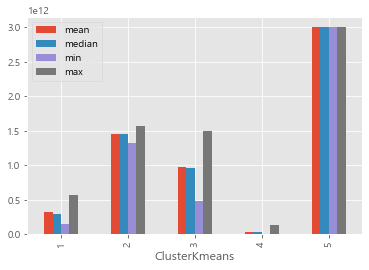

In [71]:
new_df.groupby('ClusterKmeans')['AMT'].agg(['mean','median', 'min', 'max']).plot(kind='bar')

In [72]:
cl1 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[0])]
cl2 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[1])]
cl3 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[2])]
cl4 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[3])]
cl5 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[4])]

In [73]:
cl1.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV
101,201901,서울,그외 기타 종합 소매업,10s,1,1,61,1020600,143,0
102,201901,서울,그외 기타 종합 소매업,10s,2,1,29,473960,41,0
103,201901,서울,그외 기타 종합 소매업,20s,1,1,13228,961935753,20697,0
104,201901,서울,그외 기타 종합 소매업,20s,1,2,1578,134810860,2251,0
105,201901,서울,그외 기타 종합 소매업,20s,2,1,23228,896923437,33992,0


In [75]:
cl1.to_csv('../Seoul/cl1.csv', index=False, encoding='utf-8-sig')
cl2.to_csv('../Seoul/cl2.csv', index=False, encoding='utf-8-sig')
cl3.to_csv('../Seoul/cl3.csv', index=False, encoding='utf-8-sig')
cl4.to_csv('../Seoul/cl4.csv', index=False, encoding='utf-8-sig')
cl5.to_csv('../Seoul/cl5.csv', index=False, encoding='utf-8-sig')